In [1]:
#!/usr/bin/python
'''
Evaluate how well solutions match when run multiple times, with varying sample size
'''
import sys
import os
import fnmatch
import numpy as np
from metient.util.vertex_labeling_util import LabeledTree
from metient.util.globals import *
from metient.util import eval_util as eutil

import re
import pickle

REPO_DIR = os.path.join(os.getcwd(), "../../")

DATE = "06092024"
PARAMS = "calibrate_wip_solvepoly_fixedinit_lessreg"
# plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.5)

sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
pc_map = {'mS':0, 'pS': 1, 'mM': 2, 'pM': 3, 'mR': 4, 'pR': 5}

from statannot import add_stat_annotation


<Figure size 640x480 with 0 Axes>

In [2]:
import gzip

metient_results_dir = '/data/morrisq/divyak/data/metient_prediction_results/'

def get_num_mut_trees(mut_tree_fn):
    with open(mut_tree_fn, 'r') as f:
        # look for line w/ "3 #trees" as an example
        for line in f:
            if  "#trees" in line:
                return int(line.strip().split()[0])    

def get_pckl_info(bs, run, site, mig_type, seed, tree_num, topk):
    prediction_dir = os.path.join(metient_results_dir, f'predictions_batch_exp_bs{bs}_{PARAMS}_r{run}_{DATE}')
    predicted_site_mig_type_data_dir = os.path.join(prediction_dir, site, mig_type)
    
    with gzip.open(os.path.join(predicted_site_mig_type_data_dir, f"tree{tree_num}_seed{seed}_calibrate.pkl.gz"), "rb") as f:
        pckl = pickle.load(f)
    Vs = pckl[OUT_LABElING_KEY]
    k = topk if len(Vs) >= topk else len(Vs)
    Vs = Vs[:k]
    As = pckl[OUT_ADJ_KEY][:k]
    losses = pckl[OUT_LOSSES_KEY][:k]
    return Vs, As, losses

def get_rank_to_percent_runs(solution_to_losses, solution_to_ranks, run_num_to_solutions):
    # get the avg loss across runs for each solution
    for solution in solution_to_losses:
        solution_to_losses[solution] = sum(solution_to_losses[solution])/len(solution_to_losses[solution])
        solution_to_ranks[solution] = sum(solution_to_ranks[solution])/len(solution_to_ranks[solution])
    solution_losses_list = [(k,v) for k,v in solution_to_losses.items()]
    solution_ranks_list = [(k,v) for k,v in solution_to_ranks.items()]

#     print("unsorted solution_losses_list", solution_losses_list)
#     print("unsorted solution_ranks_list", solution_ranks_list)

    solution_losses_list = sorted(solution_losses_list, key=lambda x: x[1])
    solution_ranks_list = sorted(solution_ranks_list, key=lambda x: x[1])

#     print("sorted solution_losses_list", solution_losses_list)
#     print("sorted solution_ranks_list", solution_ranks_list)

    rank_to_percent_runs = {}
    # What % of runs get the solution as a function of the rank on the joined list?
    #for rank, (soln,_) in enumerate(solution_losses_list):
    for rank, (soln,_) in enumerate(solution_ranks_list):
        rank_to_percent_runs[rank] = []
        for run in run_num_to_solutions:
            if soln in run_num_to_solutions[run]:
                rank_to_percent_runs[rank].append(run)
    print(rank_to_percent_runs)
    rank_to_percent_runs = {rank:(len(rank_to_percent_runs[rank])/num_runs) for rank in rank_to_percent_runs}
    return rank_to_percent_runs

In [3]:
from tqdm import tqdm
import torch

topk = 5 # how many of the top solutions to check for 
num_runs = 5

sites = ["m8", "m5"]
mig_types = ["M", "mS", "R", "S"]
batch_sizes = [64, 256, 1024]

print(f"matching top {topk} solutions")

m5_bs_to_rank_to_percentages = {}
m8_bs_to_rank_to_percentages = {}
all_sites_bs_to_rank_to_percentages = {}

sims_dir = os.path.join(REPO_DIR, "data/machina_sims")

for bs in batch_sizes:
    print("batch size:", bs)
    m5_bs_to_rank_to_percentages[bs] = {}
    m8_bs_to_rank_to_percentages[bs] = {}
    all_sites_bs_to_rank_to_percentages[bs] = {}
    for site in sites:
        for mig_type in mig_types:
            # Get all seeds for mig_type + site combo
            site_mig_type_dir = os.path.join(sims_dir, site, mig_type)
            seeds = fnmatch.filter(os.listdir(site_mig_type_dir), 'clustering_observed_seed*.txt')
            seeds = [s.replace(".txt", "").replace("clustering_observed_seed", "") for s in seeds]
            for seed in tqdm(seeds):
                # Get all the clone trees for this seed
                num_trees = get_num_mut_trees(os.path.join(sims_dir, f"{site}_mut_trees", f"mut_trees_{mig_type}_seed{seed}.txt"))
                num_trees = 1
                for tree_num in range(num_trees):
                    # across all the runs for this mig_type + site + seed + clone tree combo, 
                    # get the union of all solutions
                    solution_to_losses, solution_to_ranks = {}, {}
                    run_num_to_solutions = {}
                    for run in range(1,num_runs+1):
                        Vs, As, losses = get_pckl_info(bs, run, site, mig_type, seed, tree_num, topk)
                        run_num_to_solutions[run] = []
                        print(site, mig_type, seed, "tree", tree_num, "run", run)
                        for rank,(V,A,loss) in enumerate(zip(Vs, As, losses)):
                            V = torch.tensor(V)
                            A = torch.tensor(A)
                            tree = LabeledTree(A, V)                            
                            if tree not in solution_to_losses:
                                solution_to_losses[tree] = []
                                solution_to_ranks[tree] = []
                            solution_to_losses[tree].append(loss)
                            solution_to_ranks[tree].append(rank)
                            run_num_to_solutions[run].append(tree)
                    rank_to_percent_runs = get_rank_to_percent_runs(solution_to_losses, solution_to_ranks, run_num_to_solutions)
                    #print(rank_to_percent_runs)
                    bs_to_rank_to_percentages = m5_bs_to_rank_to_percentages if site == "m5" else m8_bs_to_rank_to_percentages
                    for rank in rank_to_percent_runs:
                        if rank not in bs_to_rank_to_percentages[bs]:
                            bs_to_rank_to_percentages[bs][rank] = []
                            all_sites_bs_to_rank_to_percentages[bs][rank] = []
                        bs_to_rank_to_percentages[bs][rank].append(rank_to_percent_runs[rank])
                        all_sites_bs_to_rank_to_percentages[bs][rank].append(rank_to_percent_runs[rank])



 10%|█         | 1/10 [00:00<00:01,  5.24it/s]

matching top 5 solutions
batch size: 64
m8 M 45 tree 0 run 1
m8 M 45 tree 0 run 2
m8 M 45 tree 0 run 3
m8 M 45 tree 0 run 4
m8 M 45 tree 0 run 5
{0: [1, 3], 1: [2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 4], 6: [2], 7: [5]}


 20%|██        | 2/10 [00:00<00:01,  5.43it/s]

m8 M 7 tree 0 run 1
m8 M 7 tree 0 run 2
m8 M 7 tree 0 run 3
m8 M 7 tree 0 run 4
m8 M 7 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [2, 4, 5], 5: [1, 3], 6: [1]}
m8 M 35 tree 0 run 1
m8 M 35 tree 0 run 2


 30%|███       | 3/10 [00:00<00:01,  5.78it/s]

m8 M 35 tree 0 run 3
m8 M 35 tree 0 run 4
m8 M 35 tree 0 run 5
{0: [1, 2, 3], 1: [4, 5], 2: [1, 3], 3: [4], 4: [5], 5: [1, 2, 3], 6: [2], 7: [4], 8: [5], 9: [3], 10: [4, 5], 11: [1, 2, 3], 12: [1, 2], 13: [4], 14: [5]}
m8 M 243 tree 0 run 1
m8 M 243 tree 0 run 2
m8 M 243 tree 0 run 3
m8 M 243 tree 0 run 4
m8 M 243 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 M 216 tree 0 run 1
m8 M 216 tree 0 run 2
m8 M 216 tree 0 run 3


 70%|███████   | 7/10 [00:00<00:00,  8.60it/s]

m8 M 216 tree 0 run 4
m8 M 216 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [2, 3, 4], 2: [2], 3: [2, 3, 4], 4: [2, 3, 4], 5: [3], 6: [4]}
m8 M 239 tree 0 run 1
m8 M 239 tree 0 run 2
m8 M 239 tree 0 run 3
m8 M 239 tree 0 run 4
m8 M 239 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m8 M 19 tree 0 run 1
m8 M 19 tree 0 run 2
m8 M 19 tree 0 run 3
m8 M 19 tree 0 run 4
m8 M 19 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 4, 5], 3: [1, 2, 3, 4, 5], 4: [2], 5: [4], 6: [5]}
m8 M 76 tree 0 run 1
m8 M 76 tree 0 run 2
m8 M 76 tree 0 run 3


  0%|          | 0/10 [00:00<?, ?it/s]

m8 M 76 tree 0 run 4
m8 M 76 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [2], 5: [1, 3, 4], 6: [2, 5]}
m8 M 172 tree 0 run 1
m8 M 172 tree 0 run 2
m8 M 172 tree 0 run 3
m8 M 172 tree 0 run 4
m8 M 172 tree 0 run 5
{0: [1], 1: [2, 4], 2: [3, 5], 3: [1], 4: [2, 4], 5: [3, 5], 6: [1], 7: [2, 4], 8: [3, 5], 9: [2]}
m8 M 241 tree 0 run 1
m8 M 241 tree 0 run 2
m8 M 241 tree 0 run 3
m8 M 241 tree 0 run 4
m8 M 241 tree 0 run 5
{0: [3, 4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 5]}


 10%|█         | 1/10 [00:00<00:00,  9.99it/s]

m8 mS 0 tree 0 run 1
m8 mS 0 tree 0 run 2
m8 mS 0 tree 0 run 3
m8 mS 0 tree 0 run 4
m8 mS 0 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 3], 2: [1, 2, 4, 5], 3: [3], 4: [1, 2], 5: [2, 4, 5], 6: [1, 4], 7: [5], 8: [3, 5], 9: [2], 10: [3], 11: [4]}
m8 mS 7 tree 0 run 1
m8 mS 7 tree 0 run 2
m8 mS 7 tree 0 run 3
m8 mS 7 tree 0 run 4
m8 mS 7 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 mS 4 tree 0 run 1
m8 mS 4 tree 0 run 2
m8 mS 4 tree 0 run 3
m8 mS 4 tree 0 run 4
m8 mS 4 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 3]}
m8 mS 9 tree 0 run 1


 40%|████      | 4/10 [00:00<00:00, 11.30it/s]

m8 mS 9 tree 0 run 2
m8 mS 9 tree 0 run 3
m8 mS 9 tree 0 run 4
m8 mS 9 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [2, 3, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4], 4: [5], 5: [1, 2, 3, 4, 5], 6: [1, 5]}
m8 mS 8 tree 0 run 1
m8 mS 8 tree 0 run 2
m8 mS 8 tree 0 run 3
m8 mS 8 tree 0 run 4
m8 mS 8 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 mS 3 tree 0 run 1
m8 mS 3 tree 0 run 2
m8 mS 3 tree 0 run 3
m8 mS 3 tree 0 run 4


 70%|███████   | 7/10 [00:00<00:00, 10.77it/s]

m8 mS 3 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 5], 3: [1, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 3, 4]}
m8 mS 12 tree 0 run 1
m8 mS 12 tree 0 run 2
m8 mS 12 tree 0 run 3
m8 mS 12 tree 0 run 4
m8 mS 12 tree 0 run 5
{0: [1, 4, 5], 1: [2], 2: [3], 3: [1, 4], 4: [2], 5: [3], 6: [1], 7: [2], 8: [3], 9: [4, 5], 10: [1, 4, 5], 11: [2], 12: [3], 13: [4, 5], 14: [1], 15: [2], 16: [3], 17: [5]}
m8 mS 10 tree 0 run 1
m8 mS 10 tree 0 run 2
m8 mS 10 tree 0 run 3


 90%|█████████ | 9/10 [00:00<00:00,  8.90it/s]

m8 mS 10 tree 0 run 4
m8 mS 10 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1], 2: [2], 3: [4], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2, 3, 4, 5], 7: [3, 5]}
m8 mS 2 tree 0 run 1
m8 mS 2 tree 0 run 2
m8 mS 2 tree 0 run 3
m8 mS 2 tree 0 run 4
m8 mS 2 tree 0 run 5
{0: [1], 1: [2], 2: [1], 3: [2], 4: [2, 3], 5: [3], 6: [4, 5], 7: [4], 8: [5], 9: [2, 5], 10: [3], 11: [4], 12: [1, 4], 13: [1], 14: [3], 15: [4], 16: [5], 17: [1], 18: [2], 19: [3], 20: [5]}
m8 mS 5 tree 0 run 1


 20%|██        | 2/10 [00:00<00:00, 13.51it/s]

m8 mS 5 tree 0 run 2
m8 mS 5 tree 0 run 3
m8 mS 5 tree 0 run 4
m8 mS 5 tree 0 run 5
{0: [1, 2, 3, 4], 1: [5], 2: [1, 2, 3, 4], 3: [1, 2, 3, 4], 4: [1, 2, 3, 4], 5: [1, 2, 3, 4]}
m8 R 10157 tree 0 run 1
m8 R 10157 tree 0 run 2
m8 R 10157 tree 0 run 3
m8 R 10157 tree 0 run 4
m8 R 10157 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5]}
m8 R 1070 tree 0 run 1
m8 R 1070 tree 0 run 2
m8 R 1070 tree 0 run 3
m8 R 1070 tree 0 run 4
m8 R 1070 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 4, 5], 2: [1, 2, 5], 3: [1, 2, 3, 4, 5], 4: [2, 3, 4, 5], 5: [1, 2, 3, 4], 6: [3]}


 30%|███       | 3/10 [00:00<00:00, 11.13it/s]

m8 R 9 tree 0 run 1
m8 R 9 tree 0 run 2
m8 R 9 tree 0 run 3
m8 R 9 tree 0 run 4
m8 R 9 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 4], 2: [3], 3: [3, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2, 4, 5]}
m8 R 905 tree 0 run 1
m8 R 905 tree 0 run 2
m8 R 905 tree 0 run 3
m8 R 905 tree 0 run 4
m8 R 905 tree 0 run 5
{0: [1, 2, 3, 5], 1: [4], 2: [2, 3, 5], 3: [4], 4: [1, 2, 3, 5], 5: [4], 6: [1, 3, 5], 7: [4], 8: [1, 2, 5], 9: [1, 2, 3], 10: [4]}
m8 R 10046 tree 0 run 1


 50%|█████     | 5/10 [00:00<00:00, 11.16it/s]

m8 R 10046 tree 0 run 2
m8 R 10046 tree 0 run 3
m8 R 10046 tree 0 run 4
m8 R 10046 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 R 394 tree 0 run 1
m8 R 394 tree 0 run 2
m8 R 394 tree 0 run 3
m8 R 394 tree 0 run 4
m8 R 394 tree 0 run 5
{0: [4], 1: [1, 2, 3, 4, 5], 2: [4], 3: [1, 2], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5], 6: [1, 2, 3, 5], 7: [3], 8: [5]}
m8 R 981 tree 0 run 1
m8 R 981 tree 0 run 2
m8 R 981 tree 0 run 3
m8 R 981 tree 0 run 4
m8 R 981 tree 0 run 5


  0%|          | 0/10 [00:00<?, ?it/s]

{0: [1, 2, 3, 4, 5], 1: [1, 3, 4], 2: [5], 3: [2, 3], 4: [1, 4, 5], 5: [2, 3, 4], 6: [1], 7: [2], 8: [5], 9: [1], 10: [2], 11: [3, 4], 12: [5]}
m8 R 383 tree 0 run 1
m8 R 383 tree 0 run 2
m8 R 383 tree 0 run 3
m8 R 383 tree 0 run 4
m8 R 383 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 4], 2: [1, 2, 3, 4], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 5], 5: [2, 3, 4, 5], 6: [5]}
m8 R 30342 tree 0 run 1
m8 R 30342 tree 0 run 2
m8 R 30342 tree 0 run 3
m8 R 30342 tree 0 run 4
m8 R 30342 tree 0 run 5
{0: [1], 1: [2, 3, 4, 5], 2: [2, 4, 5], 3: [2, 5], 4: [2, 5]}
m8 R 157 tree 0 run 1
m8 R 157 tree 0 run 2
m8 R 157 tree 0 run 3
m8 R 157 tree 0 run 4
m8 R 157 tree 0 run 5
{0: [1, 2, 3, 5], 1: [4], 2: [1, 3, 5], 3: [4], 4: [1], 5: [4], 6: [5], 7: [2, 3], 8: [1, 2, 3, 5], 9: [1], 10: [4], 11: [5], 12: [2, 3], 13: [2], 14: [4]}
m8 S 0 tree 0 run 1


 10%|█         | 1/10 [00:00<00:01,  6.53it/s]

m8 S 0 tree 0 run 2
m8 S 0 tree 0 run 3
m8 S 0 tree 0 run 4
m8 S 0 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [1, 2, 3, 4, 5], 3: [1, 3], 4: [2, 4, 5], 5: [3], 6: [1, 2, 3, 4, 5], 7: [1, 4], 8: [5]}
m8 S 35 tree 0 run 1
m8 S 35 tree 0 run 2
m8 S 35 tree 0 run 3
m8 S 35 tree 0 run 4
m8 S 35 tree 0 run 5


 30%|███       | 3/10 [00:00<00:00,  7.42it/s]

{0: [1, 2, 4, 5], 1: [3], 2: [1, 4], 3: [3], 4: [1, 2, 4, 5], 5: [3], 6: [2, 4, 5], 7: [1, 5], 8: [3], 9: [2, 4], 10: [1], 11: [2], 12: [3], 13: [5]}
m8 S 37 tree 0 run 1
m8 S 37 tree 0 run 2
m8 S 37 tree 0 run 3
m8 S 37 tree 0 run 4
m8 S 37 tree 0 run 5
{0: [1], 1: [2], 2: [3], 3: [4], 4: [1, 5], 5: [3], 6: [3, 5], 7: [1], 8: [5], 9: [1, 2, 4], 10: [1, 2, 5], 11: [2, 4], 12: [2, 4], 13: [3], 14: [5], 15: [3], 16: [4]}
m8 S 31 tree 0 run 1
m8 S 31 tree 0 run 2
m8 S 31 tree 0 run 3
m8 S 31 tree 0 run 4


 50%|█████     | 5/10 [00:00<00:00,  8.13it/s]

m8 S 31 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2, 3, 5], 3: [2, 4], 4: [1, 3, 4, 5], 5: [1, 2, 3, 5], 6: [1, 4]}
m8 S 69 tree 0 run 1
m8 S 69 tree 0 run 2
m8 S 69 tree 0 run 3
m8 S 69 tree 0 run 4
m8 S 69 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 S 54 tree 0 run 1
m8 S 54 tree 0 run 2
m8 S 54 tree 0 run 3
m8 S 54 tree 0 run 4
m8 S 54 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 S 12 tree 0 run 1
m8 S 12 tree 0 run 2
m8 S 12 tree 0 run 3


 80%|████████  | 8/10 [00:00<00:00,  9.56it/s]

m8 S 12 tree 0 run 4
m8 S 12 tree 0 run 5
{0: [1], 1: [2, 3, 4, 5], 2: [1], 3: [2], 4: [3, 4], 5: [1], 6: [2, 3, 4], 7: [1], 8: [2, 3, 4, 5], 9: [2, 3, 4], 10: [1]}
m8 S 23 tree 0 run 1
m8 S 23 tree 0 run 2
m8 S 23 tree 0 run 3
m8 S 23 tree 0 run 4
m8 S 23 tree 0 run 5
{0: [1, 2, 3, 5], 1: [4], 2: [4], 3: [1, 2, 3, 5], 4: [1, 2, 3], 5: [4], 6: [1, 3, 5], 7: [4], 8: [1, 2, 3, 5], 9: [2], 10: [4], 11: [5]}
m8 S 2 tree 0 run 1
m8 S 2 tree 0 run 2
m8 S 2 tree 0 run 3
m8 S 2 tree 0 run 4
m8 S 2 tree 0 run 5


  0%|          | 0/10 [00:00<?, ?it/s]

{0: [1], 1: [2], 2: [1], 3: [1, 3, 4], 4: [2], 5: [3], 6: [1, 2, 3, 4, 5], 7: [1], 8: [2, 3, 4, 5], 9: [2, 4, 5], 10: [3, 4, 5], 11: [5]}
m8 S 5 tree 0 run 1
m8 S 5 tree 0 run 2
m8 S 5 tree 0 run 3
m8 S 5 tree 0 run 4
m8 S 5 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [3], 3: [4], 4: [1, 3, 4, 5], 5: [2], 6: [1, 3, 4, 5], 7: [2], 8: [1, 3, 4, 5], 9: [1, 5], 10: [2]}
m5 M 209 tree 0 run 1
m5 M 209 tree 0 run 2
m5 M 209 tree 0 run 3
m5 M 209 tree 0 run 4
m5 M 209 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [5], 2: [1, 2, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 M 534 tree 0 run 1
m5 M 534 tree 0 run 2
m5 M 534 tree 0 run 3
m5 M 534 tree 0 run 4
m5 M 534 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 5], 3: [1, 2, 3, 4, 5], 4: [1, 3, 4], 5: [2, 4, 5]}
m5 M 694 tree 0 run 1
m5 M 694 tree 0 run 2
m5 M 694 tree 0 run 3
m5 M 694 tree 0 run 4
m5 M 694 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5]}
m5 M 512 tree 0 run 1
m5 M 512 tree 0 run 2
m5 M 5

  0%|          | 0/10 [00:00<?, ?it/s]

m5 M 907 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 4, 5], 5: [2, 3]}
m5 M 76 tree 0 run 1
m5 M 76 tree 0 run 2
m5 M 76 tree 0 run 3
m5 M 76 tree 0 run 4
m5 M 76 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m5 M 565 tree 0 run 1
m5 M 565 tree 0 run 2
m5 M 565 tree 0 run 3
m5 M 565 tree 0 run 4
m5 M 565 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 M 473 tree 0 run 1
m5 M 473 tree 0 run 2
m5 M 473 tree 0 run 3
m5 M 473 tree 0 run 4
m5 M 473 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 mS 0 tree 0 run 1
m5 mS 0 tree 0 run 2
m5 mS 0 tree 0 run 3
m5 mS 0 tree 0 run 4
m5 mS 0 tree 0 run 5
{0: [1, 2, 3, 4, 5]}
m5 mS 7 tree 0 run 1
m5 mS 7 tree 0 run 2
m5 mS 7 tree 0 run 3
m5 mS 7 tree 0 run 4
m5 mS 7 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 mS 4 tree 0 run 1
m5 mS 4 tree 0 run 2
m5 mS 4 tree 0 run 3
m5 mS 4 tree 0 run 4
m5 mS 4 tree 0 run 5
{0: [1,

  0%|          | 0/10 [00:00<?, ?it/s]

m5 R 2155 tree 0 run 4
m5 R 2155 tree 0 run 5
{0: [1, 5], 1: [2], 2: [3], 3: [4], 4: [2], 5: [3], 6: [4], 7: [1, 3, 5], 8: [2], 9: [4], 10: [1, 3, 5], 11: [2], 12: [4], 13: [1, 3, 5], 14: [1, 5], 15: [4]}
m5 R 950 tree 0 run 1
m5 R 950 tree 0 run 2
m5 R 950 tree 0 run 3
m5 R 950 tree 0 run 4
m5 R 950 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m5 R 247 tree 0 run 1
m5 R 247 tree 0 run 2
m5 R 247 tree 0 run 3
m5 R 247 tree 0 run 4
m5 R 247 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 4, 5], 3: [1, 2], 4: [1, 3, 4, 5], 5: [2, 3, 5], 6: [3, 4]}
m5 R 955 tree 0 run 1
m5 R 955 tree 0 run 2
m5 R 955 tree 0 run 3
m5 R 955 tree 0 run 4
m5 R 955 tree 0 run 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 R 518 tree 0 run 1
m5 R 518 tree 0 run 2
m5 R 518 tree 0 run 3
m5 R 518 tree 0 run 4
m5 R 518 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 R 17 tree 0 run 1
m5 R 17 tree

 50%|█████     | 5/10 [00:00<00:00, 27.05it/s]

m5 S 49 tree 0 run 3
m5 S 49 tree 0 run 4
m5 S 49 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 5], 4: [1, 4, 5], 5: [2, 3, 4]}
m5 S 35 tree 0 run 1
m5 S 35 tree 0 run 2
m5 S 35 tree 0 run 3
m5 S 35 tree 0 run 4
m5 S 35 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 S 25 tree 0 run 1
m5 S 25 tree 0 run 2
m5 S 25 tree 0 run 3
m5 S 25 tree 0 run 4
m5 S 25 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 S 31 tree 0 run 1
m5 S 31 tree 0 run 2
m5 S 31 tree 0 run 3
m5 S 31 tree 0 run 4
m5 S 31 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m5 S 81 tree 0 run 1
m5 S 81 tree 0 run 2
m5 S 81 tree 0 run 3
m5 S 81 tree 0 run 4
m5 S 81 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 4, 5], 4: [1, 2, 3, 4, 5], 5: [3]}
m5 S 40 tree 0 run 1
m5 S 40 tree 0 run 2
m5 S 40 tree 0 run 3
m5 S 40 tree 0 run 4
m5 S 40 tree 0 run 5
{0: [1, 4, 5], 1: [2, 3], 2: [1, 4, 5

 10%|█         | 1/10 [00:00<00:01,  8.93it/s]

m5 S 62 tree 0 run 3
m5 S 62 tree 0 run 4
m5 S 62 tree 0 run 5
{0: [1, 2, 3, 4, 5]}
m5 S 17 tree 0 run 1
m5 S 17 tree 0 run 2
m5 S 17 tree 0 run 3
m5 S 17 tree 0 run 4
m5 S 17 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
batch size: 256
m8 M 45 tree 0 run 1
m8 M 45 tree 0 run 2
m8 M 45 tree 0 run 3
m8 M 45 tree 0 run 4
m8 M 45 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 3, 5], 2: [4], 3: [2, 5], 4: [4], 5: [1, 2, 3, 4, 5], 6: [1, 2, 3, 4, 5], 7: [1, 2, 3]}
m8 M 7 tree 0 run 1
m8 M 7 tree 0 run 2
m8 M 7 tree 0 run 3


 30%|███       | 3/10 [00:00<00:00,  8.01it/s]

m8 M 7 tree 0 run 4
m8 M 7 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 M 35 tree 0 run 1
m8 M 35 tree 0 run 2
m8 M 35 tree 0 run 3
m8 M 35 tree 0 run 4
m8 M 35 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [2, 3, 5], 2: [1, 2, 3, 4, 5], 3: [1, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4]}
m8 M 243 tree 0 run 1
m8 M 243 tree 0 run 2


 50%|█████     | 5/10 [00:00<00:00,  8.99it/s]

m8 M 243 tree 0 run 3
m8 M 243 tree 0 run 4
m8 M 243 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 M 216 tree 0 run 1
m8 M 216 tree 0 run 2
m8 M 216 tree 0 run 3
m8 M 216 tree 0 run 4
m8 M 216 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 M 239 tree 0 run 1
m8 M 239 tree 0 run 2
m8 M 239 tree 0 run 3
m8 M 239 tree 0 run 4
m8 M 239 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m8 M 19 tree 0 run 1
m8 M 19 tree 0 run 2
m8 M 19 tree 0 run 3
m8 M 19 tree 0 run 4


 80%|████████  | 8/10 [00:00<00:00,  9.81it/s]

m8 M 19 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 4], 5: [2], 6: [3], 7: [5]}
m8 M 76 tree 0 run 1
m8 M 76 tree 0 run 2
m8 M 76 tree 0 run 3
m8 M 76 tree 0 run 4
m8 M 76 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 M 172 tree 0 run 1
m8 M 172 tree 0 run 2
m8 M 172 tree 0 run 3


 10%|█         | 1/10 [00:00<00:00,  9.65it/s]

m8 M 172 tree 0 run 4
m8 M 172 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2]}
m8 M 241 tree 0 run 1
m8 M 241 tree 0 run 2
m8 M 241 tree 0 run 3
m8 M 241 tree 0 run 4
m8 M 241 tree 0 run 5
{0: [1, 3, 4], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [2, 5]}
m8 mS 0 tree 0 run 1
m8 mS 0 tree 0 run 2
m8 mS 0 tree 0 run 3
m8 mS 0 tree 0 run 4
m8 mS 0 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [5]}


 30%|███       | 3/10 [00:00<00:00, 11.38it/s]

m8 mS 7 tree 0 run 1
m8 mS 7 tree 0 run 2
m8 mS 7 tree 0 run 3
m8 mS 7 tree 0 run 4
m8 mS 7 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 mS 4 tree 0 run 1
m8 mS 4 tree 0 run 2
m8 mS 4 tree 0 run 3
m8 mS 4 tree 0 run 4
m8 mS 4 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 mS 9 tree 0 run 1
m8 mS 9 tree 0 run 2
m8 mS 9 tree 0 run 3
m8 mS 9 tree 0 run 4
m8 mS 9 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 mS 8 tree 0 run 1
m8 mS 8 tree 0 run 2
m8 mS 8 tree 0 run 3
m8 mS 8 tree 0 run 4


 60%|██████    | 6/10 [00:00<00:00,  8.83it/s]

m8 mS 8 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 mS 3 tree 0 run 1
m8 mS 3 tree 0 run 2
m8 mS 3 tree 0 run 3
m8 mS 3 tree 0 run 4
m8 mS 3 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 4, 5], 5: [3]}
m8 mS 12 tree 0 run 1


 70%|███████   | 7/10 [00:00<00:00,  6.75it/s]

m8 mS 12 tree 0 run 2
m8 mS 12 tree 0 run 3
m8 mS 12 tree 0 run 4
m8 mS 12 tree 0 run 5
{0: [1, 3, 4], 1: [2, 5], 2: [2, 5], 3: [1, 3, 4], 4: [1, 3, 4], 5: [5], 6: [2, 5], 7: [1, 3, 4], 8: [2, 5], 9: [1, 4], 10: [2], 11: [3]}
m8 mS 10 tree 0 run 1
m8 mS 10 tree 0 run 2
m8 mS 10 tree 0 run 3
m8 mS 10 tree 0 run 4
m8 mS 10 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 4, 5], 2: [1, 3, 5], 3: [4], 4: [1, 3], 5: [1, 2, 3, 4, 5], 6: [2, 3, 4, 5], 7: [2]}


  0%|          | 0/10 [00:00<?, ?it/s]

m8 mS 2 tree 0 run 1
m8 mS 2 tree 0 run 2
m8 mS 2 tree 0 run 3
m8 mS 2 tree 0 run 4
m8 mS 2 tree 0 run 5
{0: [1, 2, 4], 1: [3], 2: [5], 3: [1, 2, 4], 4: [3], 5: [3, 5], 6: [5], 7: [1, 2, 4], 8: [1, 2, 4], 9: [3], 10: [5], 11: [1, 2, 4], 12: [3], 13: [5]}
m8 mS 5 tree 0 run 1
m8 mS 5 tree 0 run 2
m8 mS 5 tree 0 run 3
m8 mS 5 tree 0 run 4
m8 mS 5 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 R 10157 tree 0 run 1


 20%|██        | 2/10 [00:00<00:00, 10.06it/s]

m8 R 10157 tree 0 run 2
m8 R 10157 tree 0 run 3
m8 R 10157 tree 0 run 4
m8 R 10157 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5]}
m8 R 1070 tree 0 run 1
m8 R 1070 tree 0 run 2
m8 R 1070 tree 0 run 3
m8 R 1070 tree 0 run 4
m8 R 1070 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 R 9 tree 0 run 1


 30%|███       | 3/10 [00:00<00:00,  9.29it/s]

m8 R 9 tree 0 run 2
m8 R 9 tree 0 run 3
m8 R 9 tree 0 run 4
m8 R 9 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 5], 5: [1, 4], 6: [2, 3, 5]}
m8 R 905 tree 0 run 1
m8 R 905 tree 0 run 2
m8 R 905 tree 0 run 3


 40%|████      | 4/10 [00:00<00:00,  8.37it/s]

m8 R 905 tree 0 run 4
m8 R 905 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 R 10046 tree 0 run 1
m8 R 10046 tree 0 run 2
m8 R 10046 tree 0 run 3
m8 R 10046 tree 0 run 4
m8 R 10046 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 R 394 tree 0 run 1
m8 R 394 tree 0 run 2
m8 R 394 tree 0 run 3
m8 R 394 tree 0 run 4


 70%|███████   | 7/10 [00:00<00:00,  7.37it/s]

m8 R 394 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 4, 5], 3: [1, 5], 4: [1, 2, 3, 4, 5], 5: [2, 3, 4], 6: [3]}
m8 R 981 tree 0 run 1
m8 R 981 tree 0 run 2
m8 R 981 tree 0 run 3
m8 R 981 tree 0 run 4
m8 R 981 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}


 80%|████████  | 8/10 [00:00<00:00,  7.99it/s]

m8 R 383 tree 0 run 1
m8 R 383 tree 0 run 2
m8 R 383 tree 0 run 3
m8 R 383 tree 0 run 4
m8 R 383 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 R 30342 tree 0 run 1
m8 R 30342 tree 0 run 2
m8 R 30342 tree 0 run 3
m8 R 30342 tree 0 run 4
m8 R 30342 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 R 157 tree 0 run 1
m8 R 157 tree 0 run 2
m8 R 157 tree 0 run 3


  0%|          | 0/10 [00:00<?, ?it/s]

m8 R 157 tree 0 run 4
m8 R 157 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2], 3: [4], 4: [5], 5: [1, 3, 4], 6: [1, 2, 3], 7: [1, 3, 4, 5], 8: [2, 5]}
m8 S 0 tree 0 run 1
m8 S 0 tree 0 run 2
m8 S 0 tree 0 run 3


 10%|█         | 1/10 [00:00<00:02,  3.56it/s]

m8 S 0 tree 0 run 4
m8 S 0 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 5], 5: [4]}
m8 S 35 tree 0 run 1
m8 S 35 tree 0 run 2
m8 S 35 tree 0 run 3
m8 S 35 tree 0 run 4


 30%|███       | 3/10 [00:00<00:01,  4.66it/s]

m8 S 35 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 S 37 tree 0 run 1
m8 S 37 tree 0 run 2
m8 S 37 tree 0 run 3
m8 S 37 tree 0 run 4
m8 S 37 tree 0 run 5
{0: [1], 1: [4], 2: [1, 2], 3: [3, 5], 4: [2, 5], 5: [4], 6: [1, 2], 7: [4], 8: [5], 9: [1, 2, 3, 5], 10: [3], 11: [4], 12: [1, 2, 3, 5], 13: [3], 14: [4]}


 40%|████      | 4/10 [00:00<00:01,  4.32it/s]

m8 S 31 tree 0 run 1
m8 S 31 tree 0 run 2
m8 S 31 tree 0 run 3
m8 S 31 tree 0 run 4
m8 S 31 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 4], 5: [3, 5]}
m8 S 69 tree 0 run 1
m8 S 69 tree 0 run 2
m8 S 69 tree 0 run 3
m8 S 69 tree 0 run 4


 60%|██████    | 6/10 [00:01<00:00,  5.27it/s]

m8 S 69 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 S 54 tree 0 run 1
m8 S 54 tree 0 run 2
m8 S 54 tree 0 run 3
m8 S 54 tree 0 run 4
m8 S 54 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [3], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 S 12 tree 0 run 1
m8 S 12 tree 0 run 2
m8 S 12 tree 0 run 3
m8 S 12 tree 0 run 4
m8 S 12 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 5], 5: [3, 4]}


 90%|█████████ | 9/10 [00:01<00:00,  6.58it/s]

m8 S 23 tree 0 run 1
m8 S 23 tree 0 run 2
m8 S 23 tree 0 run 3
m8 S 23 tree 0 run 4
m8 S 23 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 S 2 tree 0 run 1
m8 S 2 tree 0 run 2
m8 S 2 tree 0 run 3
m8 S 2 tree 0 run 4
m8 S 2 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [4]}


  0%|          | 0/10 [00:00<?, ?it/s]

m8 S 5 tree 0 run 1
m8 S 5 tree 0 run 2
m8 S 5 tree 0 run 3
m8 S 5 tree 0 run 4
m8 S 5 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 M 209 tree 0 run 1
m5 M 209 tree 0 run 2
m5 M 209 tree 0 run 3
m5 M 209 tree 0 run 4
m5 M 209 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [2], 2: [1, 2, 3, 4, 5], 3: [4], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3, 4, 5]}
m5 M 534 tree 0 run 1
m5 M 534 tree 0 run 2
m5 M 534 tree 0 run 3
m5 M 534 tree 0 run 4
m5 M 534 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 M 694 tree 0 run 1
m5 M 694 tree 0 run 2
m5 M 694 tree 0 run 3
m5 M 694 tree 0 run 4
m5 M 694 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5]}
m5 M 512 tree 0 run 1
m5 M 512 tree 0 run 2
m5 M 512 tree 0 run 3
m5 M 512 tree 0 run 4


 60%|██████    | 6/10 [00:00<00:00, 23.57it/s]

m5 M 512 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 M 545 tree 0 run 1
m5 M 545 tree 0 run 2
m5 M 545 tree 0 run 3
m5 M 545 tree 0 run 4
m5 M 545 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 M 865 tree 0 run 1
m5 M 865 tree 0 run 2
m5 M 865 tree 0 run 3
m5 M 865 tree 0 run 4
m5 M 865 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 M 907 tree 0 run 1
m5 M 907 tree 0 run 2
m5 M 907 tree 0 run 3


  0%|          | 0/10 [00:00<?, ?it/s]

m5 M 907 tree 0 run 4
m5 M 907 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 M 76 tree 0 run 1
m5 M 76 tree 0 run 2
m5 M 76 tree 0 run 3
m5 M 76 tree 0 run 4
m5 M 76 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m5 M 565 tree 0 run 1
m5 M 565 tree 0 run 2
m5 M 565 tree 0 run 3
m5 M 565 tree 0 run 4
m5 M 565 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 M 473 tree 0 run 1
m5 M 473 tree 0 run 2
m5 M 473 tree 0 run 3
m5 M 473 tree 0 run 4
m5 M 473 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 mS 0 tree 0 run 1
m5 mS 0 tree 0 run 2
m5 mS 0 tree 0 run 3
m5 mS 0 tree 0 run 4
m5 mS 0 tree 0 run 5
{0: [1, 2, 3, 4, 5]}
m5 mS 7 tree 0 run 1
m5 mS 7 tree 0 run 2
m5 mS 7 tree 0 run 3
m5 mS 7 tree 0 run 4
m5 mS 7 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 mS 4 tree 0 run 1
m5 mS 4 tree 0 run 2
m5 mS 4 tree 0 run 3
m5 mS 4 tree 0 run 4
m5 mS 4 tre

  0%|          | 0/10 [00:00<?, ?it/s]

m5 R 981 tree 0 run 1
m5 R 981 tree 0 run 2
m5 R 981 tree 0 run 3
m5 R 981 tree 0 run 4
m5 R 981 tree 0 run 5
{0: [1, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5]}
m5 R 2155 tree 0 run 1
m5 R 2155 tree 0 run 2
m5 R 2155 tree 0 run 3
m5 R 2155 tree 0 run 4
m5 R 2155 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 R 950 tree 0 run 1
m5 R 950 tree 0 run 2
m5 R 950 tree 0 run 3
m5 R 950 tree 0 run 4
m5 R 950 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m5 R 247 tree 0 run 1
m5 R 247 tree 0 run 2
m5 R 247 tree 0 run 3
m5 R 247 tree 0 run 4
m5 R 247 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2, 3, 4], 4: [1, 2, 3, 4, 5], 5: [1], 6: [5]}
m5 R 955 tree 0 run 1
m5 R 955 tree 0 run 2
m5 R 955 tree 0 run 3
m5 R 955 tree 0 run 4
m5 R 955 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 

 10%|█         | 1/10 [00:00<00:01,  8.21it/s]

m5 S 49 tree 0 run 1
m5 S 49 tree 0 run 2
m5 S 49 tree 0 run 3
m5 S 49 tree 0 run 4
m5 S 49 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4], 5: [5]}
m5 S 35 tree 0 run 1
m5 S 35 tree 0 run 2
m5 S 35 tree 0 run 3
m5 S 35 tree 0 run 4
m5 S 35 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 S 25 tree 0 run 1
m5 S 25 tree 0 run 2
m5 S 25 tree 0 run 3
m5 S 25 tree 0 run 4
m5 S 25 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 S 31 tree 0 run 1
m5 S 31 tree 0 run 2
m5 S 31 tree 0 run 3
m5 S 31 tree 0 run 4
m5 S 31 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m5 S 81 tree 0 run 1
m5 S 81 tree 0 run 2
m5 S 81 tree 0 run 3
m5 S 81 tree 0 run 4
m5 S 81 tree 0 run 5


 10%|█         | 1/10 [00:00<00:01,  7.97it/s]

{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 S 40 tree 0 run 1
m5 S 40 tree 0 run 2
m5 S 40 tree 0 run 3
m5 S 40 tree 0 run 4
m5 S 40 tree 0 run 5
{0: [1, 3, 4], 1: [2, 5], 2: [1, 3, 4], 3: [1, 4], 4: [1, 2, 3, 4, 5]}
m5 S 32 tree 0 run 1
m5 S 32 tree 0 run 2
m5 S 32 tree 0 run 3
m5 S 32 tree 0 run 4
m5 S 32 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 S 23 tree 0 run 1
m5 S 23 tree 0 run 2
m5 S 23 tree 0 run 3
m5 S 23 tree 0 run 4
m5 S 23 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 S 62 tree 0 run 1
m5 S 62 tree 0 run 2
m5 S 62 tree 0 run 3
m5 S 62 tree 0 run 4
m5 S 62 tree 0 run 5
{0: [1, 2, 3, 4, 5]}
m5 S 17 tree 0 run 1
m5 S 17 tree 0 run 2
m5 S 17 tree 0 run 3
m5 S 17 tree 0 run 4
m5 S 17 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
batch size: 1024
m8 M 45 tree 0 run 1
m8 M 45 tree 0 run 2
m8 M 45 tree 0 run 3
m8 M 45 tree 0 run 4
m8 M 45 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 

 20%|██        | 2/10 [00:00<00:01,  7.34it/s]

m8 M 7 tree 0 run 2
m8 M 7 tree 0 run 3
m8 M 7 tree 0 run 4
m8 M 7 tree 0 run 5
{0: [1], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [2, 3, 4, 5], 5: [1, 2, 3, 4, 5]}
m8 M 35 tree 0 run 1
m8 M 35 tree 0 run 2


 30%|███       | 3/10 [00:00<00:01,  6.53it/s]

m8 M 35 tree 0 run 3
m8 M 35 tree 0 run 4
m8 M 35 tree 0 run 5
{0: [2, 5], 1: [3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [4], 6: [1, 2, 3, 5], 7: [1, 4]}
m8 M 243 tree 0 run 1
m8 M 243 tree 0 run 2
m8 M 243 tree 0 run 3
m8 M 243 tree 0 run 4
m8 M 243 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 M 216 tree 0 run 1


 50%|█████     | 5/10 [00:00<00:00,  7.28it/s]

m8 M 216 tree 0 run 2
m8 M 216 tree 0 run 3
m8 M 216 tree 0 run 4
m8 M 216 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 M 239 tree 0 run 1
m8 M 239 tree 0 run 2
m8 M 239 tree 0 run 3
m8 M 239 tree 0 run 4
m8 M 239 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m8 M 19 tree 0 run 1
m8 M 19 tree 0 run 2
m8 M 19 tree 0 run 3
m8 M 19 tree 0 run 4


 80%|████████  | 8/10 [00:01<00:00,  7.10it/s]

m8 M 19 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 3], 5: [2], 6: [4], 7: [5]}
m8 M 76 tree 0 run 1
m8 M 76 tree 0 run 2
m8 M 76 tree 0 run 3
m8 M 76 tree 0 run 4
m8 M 76 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}


  0%|          | 0/10 [00:00<?, ?it/s]

m8 M 172 tree 0 run 1
m8 M 172 tree 0 run 2
m8 M 172 tree 0 run 3
m8 M 172 tree 0 run 4
m8 M 172 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [3], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 4]}
m8 M 241 tree 0 run 1
m8 M 241 tree 0 run 2
m8 M 241 tree 0 run 3
m8 M 241 tree 0 run 4
m8 M 241 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 mS 0 tree 0 run 1


 30%|███       | 3/10 [00:00<00:00,  9.75it/s]

m8 mS 0 tree 0 run 2
m8 mS 0 tree 0 run 3
m8 mS 0 tree 0 run 4
m8 mS 0 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 mS 7 tree 0 run 1
m8 mS 7 tree 0 run 2
m8 mS 7 tree 0 run 3
m8 mS 7 tree 0 run 4
m8 mS 7 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 mS 4 tree 0 run 1
m8 mS 4 tree 0 run 2
m8 mS 4 tree 0 run 3
m8 mS 4 tree 0 run 4
m8 mS 4 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 mS 9 tree 0 run 1


 50%|█████     | 5/10 [00:00<00:00, 10.87it/s]

m8 mS 9 tree 0 run 2
m8 mS 9 tree 0 run 3
m8 mS 9 tree 0 run 4
m8 mS 9 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 mS 8 tree 0 run 1
m8 mS 8 tree 0 run 2
m8 mS 8 tree 0 run 3
m8 mS 8 tree 0 run 4
m8 mS 8 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 mS 3 tree 0 run 1
m8 mS 3 tree 0 run 2
m8 mS 3 tree 0 run 3


 60%|██████    | 6/10 [00:00<00:00,  9.57it/s]

m8 mS 3 tree 0 run 4
m8 mS 3 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 mS 12 tree 0 run 1
m8 mS 12 tree 0 run 2
m8 mS 12 tree 0 run 3
m8 mS 12 tree 0 run 4


 80%|████████  | 8/10 [00:01<00:00,  5.98it/s]

m8 mS 12 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 3, 4, 5], 5: [2]}
m8 mS 10 tree 0 run 1
m8 mS 10 tree 0 run 2
m8 mS 10 tree 0 run 3
m8 mS 10 tree 0 run 4
m8 mS 10 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4], 2: [1, 2, 3, 4, 5], 3: [1, 2], 4: [5], 5: [1, 2, 3, 4, 5], 6: [3, 4, 5]}
m8 mS 2 tree 0 run 1
m8 mS 2 tree 0 run 2
m8 mS 2 tree 0 run 3
m8 mS 2 tree 0 run 4


  0%|          | 0/10 [00:00<?, ?it/s]

m8 mS 2 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 mS 5 tree 0 run 1
m8 mS 5 tree 0 run 2
m8 mS 5 tree 0 run 3
m8 mS 5 tree 0 run 4
m8 mS 5 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 R 10157 tree 0 run 1
m8 R 10157 tree 0 run 2
m8 R 10157 tree 0 run 3
m8 R 10157 tree 0 run 4
m8 R 10157 tree 0 run 5


 20%|██        | 2/10 [00:00<00:00,  8.86it/s]

{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5]}
m8 R 1070 tree 0 run 1
m8 R 1070 tree 0 run 2
m8 R 1070 tree 0 run 3
m8 R 1070 tree 0 run 4
m8 R 1070 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 R 9 tree 0 run 1
m8 R 9 tree 0 run 2
m8 R 9 tree 0 run 3
m8 R 9 tree 0 run 4


 50%|█████     | 5/10 [00:00<00:00,  9.68it/s]

m8 R 9 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [4], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 2, 3], 6: [5]}
m8 R 905 tree 0 run 1
m8 R 905 tree 0 run 2
m8 R 905 tree 0 run 3
m8 R 905 tree 0 run 4
m8 R 905 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 R 10046 tree 0 run 1
m8 R 10046 tree 0 run 2
m8 R 10046 tree 0 run 3
m8 R 10046 tree 0 run 4
m8 R 10046 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 R 394 tree 0 run 1


 60%|██████    | 6/10 [00:00<00:00,  8.81it/s]

m8 R 394 tree 0 run 2
m8 R 394 tree 0 run 3
m8 R 394 tree 0 run 4
m8 R 394 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 R 981 tree 0 run 1
m8 R 981 tree 0 run 2
m8 R 981 tree 0 run 3


 80%|████████  | 8/10 [00:00<00:00,  8.27it/s]

m8 R 981 tree 0 run 4
m8 R 981 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 R 383 tree 0 run 1
m8 R 383 tree 0 run 2
m8 R 383 tree 0 run 3
m8 R 383 tree 0 run 4
m8 R 383 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 R 30342 tree 0 run 1
m8 R 30342 tree 0 run 2
m8 R 30342 tree 0 run 3
m8 R 30342 tree 0 run 4
m8 R 30342 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m8 R 157 tree 0 run 1


  0%|          | 0/10 [00:00<?, ?it/s]

m8 R 157 tree 0 run 2
m8 R 157 tree 0 run 3
m8 R 157 tree 0 run 4
m8 R 157 tree 0 run 5
{0: [1], 1: [2, 3, 4, 5], 2: [1], 3: [2, 3, 4, 5], 4: [1], 5: [2, 3, 5], 6: [1], 7: [2, 4], 8: [3, 4, 5], 9: [2, 3, 4, 5], 10: [1]}
m8 S 0 tree 0 run 1
m8 S 0 tree 0 run 2


 10%|█         | 1/10 [00:00<00:03,  2.31it/s]

m8 S 0 tree 0 run 3
m8 S 0 tree 0 run 4
m8 S 0 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 5], 5: [2, 3], 6: [4]}
m8 S 35 tree 0 run 1
m8 S 35 tree 0 run 2


 20%|██        | 2/10 [00:00<00:02,  2.72it/s]

m8 S 35 tree 0 run 3
m8 S 35 tree 0 run 4
m8 S 35 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 S 37 tree 0 run 1
m8 S 37 tree 0 run 2


 40%|████      | 4/10 [00:00<00:01,  4.23it/s]

m8 S 37 tree 0 run 3
m8 S 37 tree 0 run 4
m8 S 37 tree 0 run 5
{0: [1], 1: [2, 4, 5], 2: [1, 3], 3: [1, 3, 5], 4: [1, 2, 3], 5: [2, 3, 4, 5], 6: [2, 3, 4, 5], 7: [1, 2, 4], 8: [4], 9: [5]}
m8 S 31 tree 0 run 1
m8 S 31 tree 0 run 2
m8 S 31 tree 0 run 3
m8 S 31 tree 0 run 4
m8 S 31 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [2, 4, 5], 4: [1, 3, 4, 5], 5: [1, 2, 3]}
m8 S 69 tree 0 run 1
m8 S 69 tree 0 run 2
m8 S 69 tree 0 run 3
m8 S 69 tree 0 run 4
m8 S 69 tree 0 run 5


 70%|███████   | 7/10 [00:01<00:00,  5.51it/s]

{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m8 S 54 tree 0 run 1
m8 S 54 tree 0 run 2
m8 S 54 tree 0 run 3
m8 S 54 tree 0 run 4
m8 S 54 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5]}
m8 S 12 tree 0 run 1
m8 S 12 tree 0 run 2
m8 S 12 tree 0 run 3
m8 S 12 tree 0 run 4
m8 S 12 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 4], 5: [2, 3, 5]}
m8 S 23 tree 0 run 1
m8 S 23 tree 0 run 2
m8 S 23 tree 0 run 3
m8 S 23 tree 0 run 4
m8 S 23 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}


  0%|          | 0/10 [00:00<?, ?it/s]

m8 S 2 tree 0 run 1
m8 S 2 tree 0 run 2
m8 S 2 tree 0 run 3
m8 S 2 tree 0 run 4
m8 S 2 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [2, 3, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [1, 4]}
m8 S 5 tree 0 run 1
m8 S 5 tree 0 run 2
m8 S 5 tree 0 run 3
m8 S 5 tree 0 run 4
m8 S 5 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3], 2: [1, 2], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5], 5: [3, 4, 5], 6: [4, 5]}
m5 M 209 tree 0 run 1
m5 M 209 tree 0 run 2
m5 M 209 tree 0 run 3
m5 M 209 tree 0 run 4
m5 M 209 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4], 5: [5]}
m5 M 534 tree 0 run 1
m5 M 534 tree 0 run 2
m5 M 534 tree 0 run 3
m5 M 534 tree 0 run 4
m5 M 534 tree 0 run 5


 50%|█████     | 5/10 [00:00<00:00, 44.53it/s]

{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 M 694 tree 0 run 1
m5 M 694 tree 0 run 2
m5 M 694 tree 0 run 3
m5 M 694 tree 0 run 4
m5 M 694 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m5 M 512 tree 0 run 1
m5 M 512 tree 0 run 2
m5 M 512 tree 0 run 3
m5 M 512 tree 0 run 4
m5 M 512 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 M 545 tree 0 run 1
m5 M 545 tree 0 run 2
m5 M 545 tree 0 run 3
m5 M 545 tree 0 run 4
m5 M 545 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 M 865 tree 0 run 1
m5 M 865 tree 0 run 2
m5 M 865 tree 0 run 3


  0%|          | 0/10 [00:00<?, ?it/s]

m5 M 865 tree 0 run 4
m5 M 865 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 M 907 tree 0 run 1
m5 M 907 tree 0 run 2
m5 M 907 tree 0 run 3
m5 M 907 tree 0 run 4
m5 M 907 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 M 76 tree 0 run 1
m5 M 76 tree 0 run 2
m5 M 76 tree 0 run 3
m5 M 76 tree 0 run 4
m5 M 76 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m5 M 565 tree 0 run 1
m5 M 565 tree 0 run 2
m5 M 565 tree 0 run 3
m5 M 565 tree 0 run 4
m5 M 565 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 M 473 tree 0 run 1
m5 M 473 tree 0 run 2
m5 M 473 tree 0 run 3
m5 M 473 tree 0 run 4
m5 M 473 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 mS 0 tree 0 run 1
m5 mS 0 tree 0 run 2
m5 mS 0 tree 0 run 3
m5 mS 0 tree 0 run 4
m5 mS 0 tree 0 run 5
{0: [1, 2, 3, 4, 5]}
m5 mS 7 tree 0 run 1
m5 mS 7 t

 50%|█████     | 5/10 [00:00<00:00, 41.31it/s]

m5 mS 9 tree 0 run 4
m5 mS 9 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 mS 8 tree 0 run 1
m5 mS 8 tree 0 run 2
m5 mS 8 tree 0 run 3
m5 mS 8 tree 0 run 4
m5 mS 8 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 mS 3 tree 0 run 1
m5 mS 3 tree 0 run 2
m5 mS 3 tree 0 run 3
m5 mS 3 tree 0 run 4
m5 mS 3 tree 0 run 5
{0: [1, 2, 3, 4, 5]}
m5 mS 12 tree 0 run 1
m5 mS 12 tree 0 run 2
m5 mS 12 tree 0 run 3
m5 mS 12 tree 0 run 4
m5 mS 12 tree 0 run 5
{0: [1, 2, 3, 4, 5]}
m5 mS 10 tree 0 run 1
m5 mS 10 tree 0 run 2
m5 mS 10 tree 0 run 3
m5 mS 10 tree 0 run 4
m5 mS 10 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5]}
m5 mS 2 tree 0 run 1
m5 mS 2 tree 0 run 2
m5 mS 2 tree 0 run 3
m5 mS 2 tree 0 run 4
m5 mS 2 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 mS 5 tree 0 run 1
m5 mS 5 tree 0 run 2
m5 mS 5 tree 0 run 3
m5 mS 5 tree 0 run 4
m5 mS 5 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 R 571 tree 0 run 1
m5 R 571 tree 0 run 2
m5 R 57

  0%|          | 0/10 [00:00<?, ?it/s]

m5 R 247 tree 0 run 1
m5 R 247 tree 0 run 2
m5 R 247 tree 0 run 3
m5 R 247 tree 0 run 4
m5 R 247 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 R 955 tree 0 run 1
m5 R 955 tree 0 run 2
m5 R 955 tree 0 run 3
m5 R 955 tree 0 run 4
m5 R 955 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 R 518 tree 0 run 1
m5 R 518 tree 0 run 2
m5 R 518 tree 0 run 3
m5 R 518 tree 0 run 4
m5 R 518 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 R 17 tree 0 run 1
m5 R 17 tree 0 run 2
m5 R 17 tree 0 run 3
m5 R 17 tree 0 run 4
m5 R 17 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 S 49 tree 0 run 1
m5 S 49 tree 0 run 2
m5 S 49 tree 0 run 3
m5 S 49 tree 0 run 4


100%|██████████| 10/10 [00:00<00:00, 38.93it/s]

m5 S 49 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 5], 5: [4]}
m5 S 35 tree 0 run 1
m5 S 35 tree 0 run 2
m5 S 35 tree 0 run 3
m5 S 35 tree 0 run 4
m5 S 35 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 S 25 tree 0 run 1
m5 S 25 tree 0 run 2
m5 S 25 tree 0 run 3
m5 S 25 tree 0 run 4
m5 S 25 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5]}
m5 S 31 tree 0 run 1
m5 S 31 tree 0 run 2
m5 S 31 tree 0 run 3
m5 S 31 tree 0 run 4
m5 S 31 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5]}
m5 S 81 tree 0 run 1
m5 S 81 tree 0 run 2
m5 S 81 tree 0 run 3
m5 S 81 tree 0 run 4
m5 S 81 tree 0 run 5
{0: [1, 2, 3, 4, 5], 1: [1, 2, 3, 4, 5], 2: [1, 2, 3, 4, 5], 3: [1, 2, 3, 4, 5], 4: [1, 2, 3, 4, 5]}
m5 S 40 tree 0 run 1
m5 S 40 tree 0 run 2
m5 S 40 tree 0 run 3
m5 S 40 tree 0 run 4
m5 S 40 tree 0 run 5
{0: [1, 5], 1: [4], 2: [1, 2, 3, 5], 3: [4], 4: [1, 2, 3, 4, 5], 5: [4], 6: [4]}
m5 

In [4]:
import pandas as pd

m8_data = []
for bs in m8_bs_to_rank_to_percentages:
    for rank in m8_bs_to_rank_to_percentages[bs]:
        avg = 100*(sum(m8_bs_to_rank_to_percentages[bs][rank])/len(m8_bs_to_rank_to_percentages[bs][rank]))
        m8_data.append([rank+1, f"Metient-{bs}", avg])
m8_df = pd.DataFrame(m8_data, columns=["Rank", "Method", "% runs"])
m8_df

,Rank,Method,% runs
0,1,Metient-64,78.500
1,2,Metient-64,62.000
2,3,Metient-64,61.538
3,4,Metient-64,61.053
4,5,Metient-64,61.818
5,6,Metient-64,48.387
6,7,Metient-64,45.926
7,8,Metient-64,25.556
8,9,Metient-64,43.750
9,10,Metient-64,37.143


In [5]:
m5_data = []
for bs in m5_bs_to_rank_to_percentages:
    for rank in m5_bs_to_rank_to_percentages[bs]:
        avg = 100*(sum(m5_bs_to_rank_to_percentages[bs][rank])/len(m5_bs_to_rank_to_percentages[bs][rank]))
        m5_data.append([rank+1, f"Metient-{bs}", avg])
m5_df = pd.DataFrame(m5_data, columns=["Rank", "Method", "% runs"])
m5_df

,Rank,Method,% runs
0,1,Metient-64,91.500
1,2,Metient-64,88.000
2,3,Metient-64,88.182
3,4,Metient-64,78.000
4,5,Metient-64,78.462
5,6,Metient-64,50.000
6,7,Metient-64,33.333
7,8,Metient-64,60.000
8,9,Metient-64,20.000
9,10,Metient-64,20.000


In [6]:
all_sites_data = []
for bs in all_sites_bs_to_rank_to_percentages:
    for rank in all_sites_bs_to_rank_to_percentages[bs]:
        avg = 100*(sum(all_sites_bs_to_rank_to_percentages[bs][rank])/len(all_sites_bs_to_rank_to_percentages[bs][rank]))
        all_sites_data.append([rank+1, f"Metient-{bs}", avg])
all_sites_df = pd.DataFrame(all_sites_data, columns=["Rank", "Method", "% runs"])
all_sites_df

,Rank,Method,% runs
0,1,Metient-64,91.500
1,2,Metient-64,88.000
2,3,Metient-64,88.182
3,4,Metient-64,78.000
4,5,Metient-64,78.462
5,6,Metient-64,50.000
6,7,Metient-64,33.333
7,8,Metient-64,60.000
8,9,Metient-64,20.000
9,10,Metient-64,20.000


[(0.48942421, 0.72854938, 0.56751036), (0.34892097, 0.64828676, 0.56513633), (0.24929311, 0.56486397, 0.5586654)]


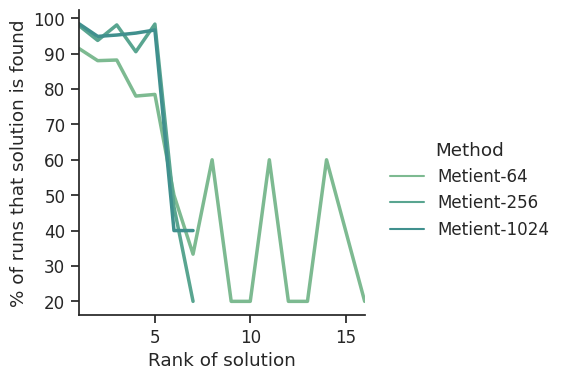

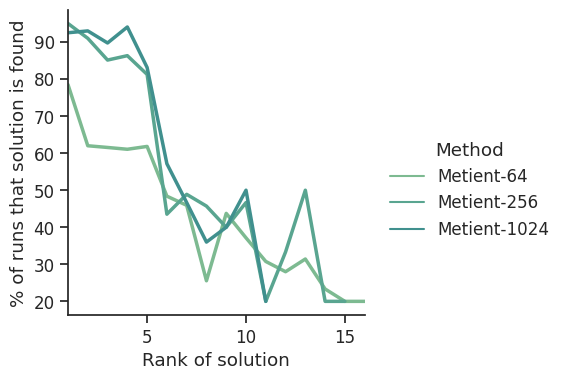

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette("crest")
colors = colors[:len(batch_sizes)]
print(colors)
sns.set_palette(sns.color_palette(colors))

for name,df in zip(["m5", "m8"], [m5_df, m8_df]):
    with sns.plotting_context("notebook", font_scale=1.1):
        g = sns.relplot(
            data=df, x="Rank", y="% runs",
            height=4, aspect=1.0, dashes=False, linewidth=2.5,
            hue="Method", style="Method", kind="line", legend=True,
        )

        (g.set_axis_labels("Rank of solution", "% of runs that solution is found")
          .set_titles("boop")
          .tight_layout(w_pad=0))
        plt.xlim(1,16)
        #sns.move_legend(g, "upper right")
        plt.show()
        

        fig = g.fig
        #out_name = ("_").join(y_labels[i].split(" ") + x.split(" "))
        fig.savefig(os.path.join(REPO_DIR, "test/output_plots", f"{name}_percent_solns_found_{PARAMS}_{DATE}.png"), dpi=600) 


[(0.48942421, 0.72854938, 0.56751036), (0.34892097, 0.64828676, 0.56513633), (0.24929311, 0.56486397, 0.5586654)]


<Figure size 400x400 with 0 Axes>

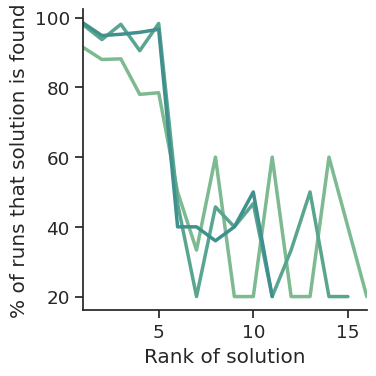

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette("crest")
colors = colors[:len(batch_sizes)]
print(colors)
sns.set(style='ticks', font="Helvetica", rc={'axes.labelsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'axes.linewidth': 1.1})
sns.set_palette(sns.color_palette(colors))
plt.figure(figsize=(2, 2), dpi=200)

with sns.plotting_context("notebook", font_scale=1.2):
    g = sns.relplot(
        data=all_sites_df, x="Rank", y="% runs",
        height=4, aspect=1.0, dashes=False, linewidth=2.5,
        hue="Method", style="Method", kind="line",  legend=False,
    )

    (g.set_axis_labels("Rank of solution", "% of runs that solution is found")
      .set_titles("boop")
      .tight_layout(w_pad=0))
    plt.xlim(1,16)
    plt.show()


    fig = g.fig
    fig.savefig(os.path.join(REPO_DIR, "test/output_plots", f"all_sites_percent_solns_found_{PARAMS}_{DATE}.png"), dpi=600) 
